# Gibbs Ensemble Monte Carlo for Vapor Liquid Equilibrium of R32 tutorial
In this tutorial, you will learn how to setup a Cassandra simulation via `mosdef_cassandra` and the Molecular Simulation Design Framework (MoSDeF) ecosystem.

MoSDeF is a set of open source tools whose goal is to allow the molecular simulation practitioner to easily setup calculations in different simulation engines. They have been developed by researchers in a University consortium that includes Vanderbilt, Michigan, Notre Dame, among others. MoSDeF include tools to generate initial configurations (mBuild), force field assignment (foyer), data management and automatic submission to University clusters and supercomputers (signac) and Python interfaces to various simulation engines such as Cassandra (`mosdef_cassandra`). They have extensions with popular molecular simulation engines such as LAMMPS, GROMACS, Cassandra, GOMC, and others.

# Colab setup

Let's first setup the required packages in colab so that we can use the package manager conda within Google Colab. Please execute the following two cells.

In [ ]:
# Note: Run this cell first and by itself.
# The kernel will be restarted after this step
# There might be an error pops up stating the session crashed
# for an unknown reason, but that is expected.
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
import condacolab
condacolab.check()

!conda install mamba

!mamba install anaconda-client -n base
!git clone https://github.com/MaginnGroup/CECAM-Workshop
!mamba env update -n base -f MaginnGroup/environment.yml
!pip install --upgrade ipykernel

%cd CECAM-workshop/gemc

# Importing the required Python packages

In [1]:
import mbuild
import foyer
import gmso
from mosdef_cassandra.analysis import ThermoProps
import mosdef_cassandra as mc
import unyt as u
import numpy as np
import pandas as pd
import subprocess

import matplotlib.pyplot as plt


# We'll filter out warnings. This is to improve the
# clarity of this tutorial. Please refrain to do this
# if you are not completely sure what these mean.

from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

/home/emarinri/miniconda3/envs/mosdef_conda/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/emarinri/miniconda3/envs/mosdef_conda/lib/python3.11/site-packages/mdtraj/geometry/order.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/emarinri/miniconda3/envs/mosdef_conda/lib/python3.11/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/emarinri/miniconda3/envs/mosdef_conda/lib/python3.11/site-packages/pkg_resource

The first module is the mBuild package. Its goal is to build the initial configuration of a simulation. It has extensions to build bulk liquids, monolayers, polymers, interfaces, porous materials, etcetera. In this tutorial, we will run a Gibbs Ensemble Monte Carlo (GEMC) simulation of the hydrofluorocarbon R32, which involves generating initial configurations of bulk systems in two phases.

The second package is foyer. Its goal is to assign the atom types and other parameters (such as bonds, angles, dihedrals and non-bonded parameters) to a system It looks at the chemical environment of a system to decide which is the best atom type to assign. Available force fields include OPLS and TraPPE.

The third package is the General Molecular Simulation Object (GMSO) package. It is a general system representation of molecular simulation data with extensions to several simulation packages such as LAMMPS, GROMACS or Cassandra.
.The remaining packages are generic Python packages for plotting, data analysis, etc.



# Methods

## Gibbs Ensemble Monte Carlo

The Gibbs Ensemble Monte Carlo (GEMC) method is a standard technique for studying phase equilibria of pure fluids and their mixtures. It is the method of choice to study vapor liquid equilibrium due to its simplicity and intuitive physical basis.

The NVT and NPT versions of this method (GEMC-NVT and GEMC-NPT) have been implemented in Cassandra and `mosdef_cassandra`. The GEMC-NVT is suitable
for simulating pure systems, as it requires the specification of only one intensive variable (temperature) to completely specify the thermodynamic state (Gibbs phase rule). The NPT version of the GEMC method allows the specification of pressure in addition to temperature, so it is suitable to simulate mixtures.

In the NVT version, the system is comprised of two boxes, A and B that are in thermodynamic equilibrium:

1) $T_A$ = $T_B$
2) $P_A$ = $P_B$
3) $\mu_A$ = $\mu_B$

In the GEMC-NVT method, the first condition, thermal equilibration, is attained by performing thermal equilibration moves, such as translation, rotation, configurational-biased regrowths, angle perturbations, dihedral changes, etc. The second condition is attained by volume exchange moves (in the NVT version of the GEMC). Finally, particle exchanges between boxes are used to attain the third condition (chemical potential equality).

In this tutorial, we will compute the vapor liquid equilibrium of the hydrofluorocarbon R32.

![The Gibbs Ensemble Monte Carlo method](gemc.png)


# Fragment-based configurational bias sampling

The goal of a Monte Carlo simulation is to generate a Markov chain of states consistent with a given statistical mechanical probability distribution. In Cassandra, a molecular fragment decomposition scheme is used to efficiently sample highly coupled molecular degrees of freedom. In this method, a molecule is decomposed into separate fragments, each of which has an associated library of conformations whose members are Boltzmann distributed. Each fragment is defined by a set of angles and has no torsional angles (unless ring moieties are involved). Using conformations drawn from this library, a molecule is reassembled in a step-by-step fashion using configurational-biased methods, as shown in the movies below.

In general, a fragment is composed of a central site bonded to two or more sites giving rise to multiple bond angles at the central site. As shown in the movie below, an ethanol molecule can be divided in three fragments, each of which has is composed by three fragments: two terminal fragments consisting of one carbon atom connected to three hydrogens and a central methylene carbon, and the second fragment consisting of a central carbon atom connected to two terminal carbon atoms and two hydrogen atoms. The use of fragments enables one to separately sample the “hard” intramolecular degrees of freedom of a molecule and the “soft” intramolecular degrees of freedom. It also ensures the correct sampling of bond angle distributions during regrowth moves involving atoms bonded to more than two other atoms. Note that Cassandra is designed to only treat molecules with fixed bond lengths. with fixed bond lengths. with fixed bond lengths.ramolecular nonbonded interactions.perature is saved to the library. 

In [4]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/eLHUjp-BOug?si=WlOHqxZOBC_Cb6fdr" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

In [6]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/3_2S_W17-oQ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

In [14]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/QvK6BZbp2Hg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>


# Overview

We will conduct the following protocol:

0. Setup the liquid system.
1. NVT at 400 K of the liquid phase.
2. NVT at 151 K of the liquid phase.
3. NpT at 151 K of the liquid phase.
4. GEMC at 151 K of the liquid and vapor phases.

# Step 0. Setup the liquid system.

We will first create an R32 molecule from a smiles string. This is very straightforward to achieve this using the `mBuild` package.

In [2]:
r32 = mbuild.load("FCF", smiles=True)
r32.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The type of `r32` is an `mb.Compound`

In [3]:
type(r32)

mbuild.compound.Compound

We are now ready to set up the liquid system. We will use the `unyt` package to compute an initial box size for the liquid box given the number of molecules and initial density. Then, we fill a box of R32 molecules using the `mBuild` package. We use a relatively small system size for computational and time constraint reasons. 

In [21]:
from scipy.constants import Avogadro

# Compute the initial density of the liquid box
Na = Avogadro / u.mole
liq_mols = 200
liq_dens = 0.9 * u.gram / (u.centimeter ** 3)
mw = 52.024 * u.gram / u.mole
vol = liq_mols / Na * mw / liq_dens
boxl = np.cbrt(vol.to("nanometer ** 3 ").value)
# Create the liquid box
liquid_box = mbuild.fill_box(r32, box=[boxl, boxl, boxl], n_compounds=liq_mols)
liquid_box.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The `liquid_box` is also an `mb.Compound`. The object `mb.Compund` is a composite of other `mb.Compound` objects, such as the R32 molecules. 

In [22]:
type(liquid_box)

mbuild.compound.Compound

Now that we have built a liquid box full of R32 molecules, we will load the R32 force field that is provided in the XML format defined by the Foyer package. Below you can see the Foyer format for the R32 molecule.

In [23]:
!cat r32.xml

<ForceField name="r32" version="0.0.1">
<AtomTypes>
 <Type name="C" class="C" element="C" mass="12.011" def="C(F)(F)" desc="central carbon"/>
 <Type name="H" class="H" element="H" mass="1.008" def="H(C)" desc="first H bonded to C1_s1"/>
 <Type name="F" class="F" element="F" mass="18.998" def="F(C)" desc="F bonded to C1_s1"/>
</AtomTypes>
<HarmonicBondForce>
 <Bond class1="C" class2="H" length="0.10961" k="277566.56"/>
 <Bond class1="C" class2="F" length="0.13497" k="298653.92"/>
</HarmonicBondForce>
<HarmonicAngleForce>
 <Angle class1="H" class2="C" class3="H" angle="1.9233528356977512" k="326.352"/>
 <Angle class1="F" class2="C" class3="H" angle="1.898743693244631" k="427.6048"/>
 <Angle class1="F" class2="C" class3="F" angle="1.8737854849411122" k="593.2912"/>
</HarmonicAngleForce>
<NonbondedForce coulomb14scale="0.833333" lj14scale="0.5">
 <Atom type="C" charge="0.405467" sigma="0.3709638067695299" epsilon="0.49512003740636584"/>
 <Atom type="H" charge="0.0480495" sigma="0.212806173

The atom types are defined in the `<AtomTypes>` section of the Foyer format as SMARTS strings, which define a substructure within the molecular graph of the R32 molecule. These substructures are directly translated to atom types.

We can read in the XML file into the `gmso.ForceField` data structure as shown below:

In [24]:
import forcefield_utilities as ffutils

converter = ffutils.FoyerFFs()
ff = converter.load("r32.xml")
r32_ff = ff.to_gmso_ff()
r32_ff

<ForceField r32,
 3 AtomTypes,
 2 BondTypes,
 3 AngleTypes,
 0 DihedralTypes,
 0 ImproperType,
 0 PairPotentialType,
 id: 140152996064272>

The variable `r32` is an `mb.Compound`. The main data structure in the GMSO is an `gmso.Topology`, which is a very flexible structure that is designed to handle a wide number of force fields, molecular models, etc. The GMSO package can take in  the type `mb.Compound`, transform it to a `gmso.Topology` and then and apply a `gmso.ForceField` to it.

In [25]:
from gmso.parameterization import apply
single_r32_top = r32.to_gmso()
single_r32_ptop = apply(single_r32_top, r32_ff, identify_connections=True)
single_r32_ptop

<Topology Topology, 5 sites,
 10 connections,
 15 potentials,
 id: 140150899308752>

The variable `single_r32_ptop` is now a `gmso.Topology`. This object has different writer functions that can be used to dump topology files for different simulation engines, such as LAMMPS, GROMACS or Cassandra. Below, we output an MCF and take a look at it.

In [26]:
single_r32_ptop.save("r32.mcf", overwrite=True)
!cat r32.mcf

!*******************************************************************************
!Molecular connectivity file
!*******************************************************************************
!File /home/emarinri/Git/CECAM-workshop/gemc/r32.mcf written by gmso 0.11.2 at 2023-09-27 17:21:16.120420

!Atom Format
!index type element mass charge vdw_type parameters
!vdw_type="LJ", parms=epsilon sigma
!vdw_type="Mie", parms=epsilon sigma repulsion_exponent dispersion_exponent

# Atom_Info
5
1     F       F    18.9980   -0.25078300  LJ     28.83110     2.82154
2     C       C    12.0110    0.40546700  LJ     59.54926     3.70964
3     F       F    18.9980   -0.25078300  LJ     28.83110     2.82154
4     H       H     1.0080    0.04804950  LJ      9.39462     2.12806
5     H       H     1.0080    0.04804950  LJ      9.39462     2.12806

!Bond Format
!index i j type parameters
!type="fixed", parms=bondLength

# Bond_Info
4
1     1     2     fixed     1.34970
2     2     3     fixed     1.34970


# Step 1. NVT at 600 K

Now we are ready to use the `mosdef_cassandra` package. The key ingredients to run a simulation with `mosdef_cassandra` are the `mosdef_cassandra.System` and `mosdef_cassandra.MoveSet` objects.

The `mosdef_cassandra.System` requires the initial configuration as `mbuild.Compound` or `mbuild.Box` objects, as well as the parametrized topologies of the molecules of interests. These can be provided as `gmso.Topology` or `parmed.Structure` instances. Additional parameters include `mol_in_boxes` which is the number of molecules in the simulation box(es).

For the case at hand, we have `liquid_box`, the parametrized R32 `single_r32_ptop` and the number of molecules in the box for the NVT simulation, `liq_mols`.

In [27]:
temperature = 600.0 * u.K
simlength = 500000

# Define the System
nvt_system = mc.System([liquid_box], [single_r32_ptop], mols_in_boxes=[[liq_mols]])
# Define the MoveSet
nvt_moveset = mc.MoveSet("nvt", [single_r32_top])
nvt_moveset.prob_regrow, nvt_moveset.prob_translate, nvt_moveset.prob_rotate

(0.34, 0.33, 0.33)

As shown above, the variable `nvt_moveset` contains the probabilities of rotation, regrowth and translation of the R32 molecules. `mosdef_cassandra` can identify what are reasonable enough moves and probabilities for a given simulation and molecule. The rules for these were defined in the code by domain experts. These can be overwritten by the user, if desired.

For R32, we have rotational and translational degrees of freedom, which are sampled by the respective moves. Intramolecular degrees of freedom, which are angles for R32, are taken care by the regrowth moves. As discussed earlier, angles are sampled by selecting configurations from the pre-generated R32 library of configurations.

We are now ready to run a simulation. The `mosdef_cassandra.run` method takes in the previously defined `mosdef_cassandra.System` and `mosdef_cassandra.MoveSet` methods, along with other arguments defining the run length, temperature, electrostatic energy calculation method, etc. Please refer to the documentation for all the available options.

In [28]:
mc.run(
    system=nvt_system,
    moveset=nvt_moveset,
    run_type="equilibration",
    run_length=simlength,
    temperature=temperature,
    charge_style="ewald",
)

Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...


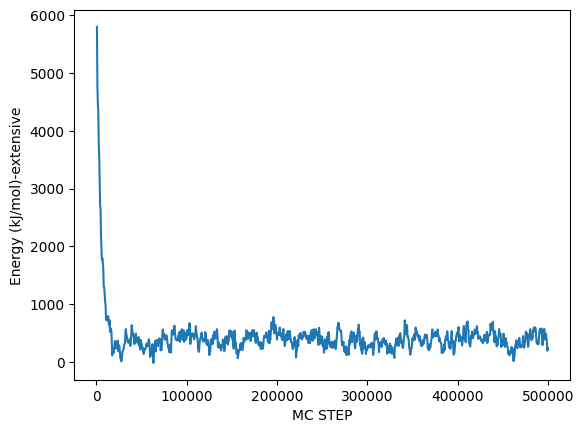

In [29]:
thermo = ThermoProps(f"nvt.out.prp")

plt.plot(thermo.prop("MC_STEP"), thermo.prop("Energy_Total"), label="Liquid")
plt.xlabel("MC STEP")
plt.ylabel("Energy (kJ/mol)-extensive")

plt.show()

# Step 2. NVT at 300 K

We continue our equilibration protocol by conducting a second NVT simulation at 300 K, which is the temperature of interest. We restart from the last configuration of the generated trajectory in the first phase. Cassandra outputs by default the XYZ format. We'll use a few bash scripts to extract the last configuration that will serve as a starting configuration for the second phase of equilibration.

The `mBuild` package contains functionality to read xyz files, which makes it ieasy to generate `mb.Compound` objects. The remaining of the script is fairly similar to the previous phase.

In [30]:
temperature = 300.0 * u.K
simlength = 500000

cmd = [
    "tail",
    "-n",
    str(liq_mols * single_r32_ptop.n_sites + 2),
    "nvt.out.xyz",
]

# Save final liquid box xyz file
xyz = subprocess.check_output(cmd).decode("utf-8")

with open("nvt2.initial.xyz", mode="w") as f:
    f.write(xyz)


liquid_box = mbuild.formats.xyz.read_xyz("nvt2.initial.xyz")

liquid_box.box = mbuild.Box(lengths=[boxl, boxl, boxl], angles=[90., 90., 90.])

box_list = [liquid_box]

species_list = [single_r32_ptop]

mols_in_boxes = [[liq_mols]]

nvt2_system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)

mc.run(
    system=nvt2_system,
    run_name="nvt2",
    moveset=nvt_moveset,
    run_type="equilibration",
    run_length=simlength,
    temperature=temperature,
    charge_style="ewald",
)

Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...


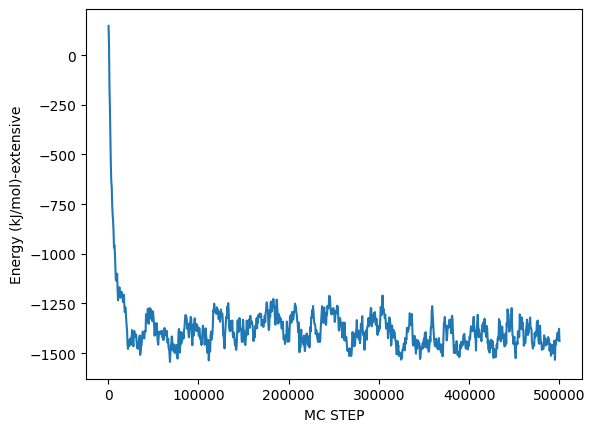

In [31]:
thermo = ThermoProps(f"nvt2.out.prp")

plt.plot(thermo.prop("MC_STEP"), thermo.prop("Energy_Total"), label="Liquid")
plt.xlabel("MC STEP")
plt.ylabel("Energy (kJ/mol)-extensive")

plt.show()

# Step 2. NPT at 300 K

Now that we have relaxed the system reasonable enough at 300 K, we can "turn on" the volume Monte Carlo moves that will relax the system towards in volume space consistent with a given pressure.

The commands are very similar to the previous phase. The key difference is that we will now use a `mosdef_cassandra.MoveSet` for an NpT simulation. This will include the volume move. We also show how to change a volume move probability if desired, as well as specify the pressure in the `mosdef_cassandra.run` method.

In [32]:
temperature = 300.0 * u.K
simlength = 10000000
pressure = 20 * u.bar

cmd = [
    "tail",
    "-n",
    str(liq_mols * single_r32_ptop.n_sites + 2),
    "nvt2.out.xyz",
]

# Save final liquid box xyz file
xyz = subprocess.check_output(cmd).decode("utf-8")

with open("npt.initial.xyz", mode="w") as f:
    f.write(xyz)

liquid_box = mbuild.formats.xyz.read_xyz("npt.initial.xyz")

liquid_box.box = mbuild.Box(lengths=[boxl, boxl, boxl], angles=[90., 90., 90.])

box_list = [liquid_box]

species_list = [single_r32_ptop]

mols_in_boxes = [[liq_mols]]

npt_system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)

npt_moveset = mc.MoveSet("npt", species_list)

# Edit the volume move probability to be more reasonable
orig_prob_volume = npt_moveset.prob_volume
new_prob_volume = 1.0 / liq_mols
npt_moveset.prob_volume = new_prob_volume

npt_moveset.prob_translate = (
    npt_moveset.prob_translate + orig_prob_volume - new_prob_volume
)

mc.run(
    system=npt_system,
    moveset=npt_moveset,
    run_type="equilibration",
    run_length=simlength,
    temperature=temperature,
    pressure=pressure,
    charge_style="ewald",
)


Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...


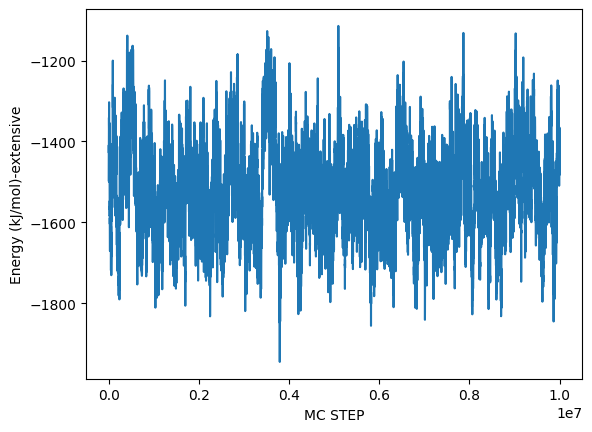

In [33]:
thermo = ThermoProps(f"npt.out.prp")

plt.plot(thermo.prop("MC_STEP"), thermo.prop("Energy_Total"), label="Liquid")
plt.xlabel("MC STEP")
plt.ylabel("Energy (kJ/mol)-extensive")

plt.show()

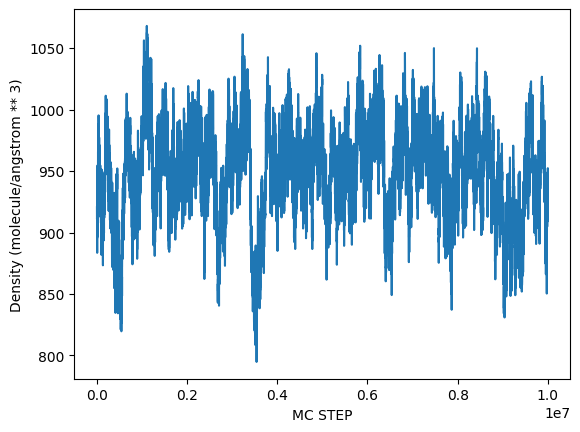

In [34]:
thermo = ThermoProps(f"npt.out.prp")

plt.plot(thermo.prop("MC_STEP"), thermo.prop("Mass_Density"), label="Liquid")
plt.xlabel("MC STEP")
plt.ylabel("Density (molecule/angstrom ** 3)")

plt.show()

# 4. GEMC at 300 K

Now that we have a reasonable density (which probably is close to the saturated liquid density), we can turn on the particle swap moves. This move uses two simulation boxes, one for the liquid and one for the vapor. Particles are transfered from one box to the other to achieve the isofugacity condition of phase equilibrium.

In [35]:
vap_mols = 50
temperature = 300.0 * u.K
simlength = 600000

cmd = [
    "tail",
    "-n",
    str(liq_mols * single_r32_ptop.n_sites + 2),
    "npt.out.xyz",
]

# Save final liquid box xyz file
xyz = subprocess.check_output(cmd).decode("utf-8")
with open("gemc.initial.xyz", "w") as f:
    f.write(xyz)

# Save final box dims
box_data = []
with open("npt.out.H") as f:
    for line in f:
        box_data.append(line.strip().split())

boxl = float(box_data[-6][0]) / 10.0  # nm

liquid_box = mbuild.formats.xyz.read_xyz("gemc.initial.xyz")

liquid_box.box = mbuild.Box(lengths=[boxl, boxl, boxl], angles=[90., 90., 90.])

specific_volume = u.kb * temperature / pressure
vap_volume = (specific_volume * vap_mols / u.Na.to("1/mole")).to("nanometer**3")
boxl_vap = vap_volume ** (1.0/3.0)
# boxl_vap = 4.5 * u.nanometer

vap_box = mbuild.Box(lengths=[boxl_vap, boxl_vap, boxl_vap], angles=[90., 90., 90.])

box_list = [liquid_box, vap_box]

species_list = [single_r32_ptop]

mols_in_boxes = [[liq_mols], [0]]

mols_to_add = [[0], [vap_mols]]

gemc_system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes, mols_to_add=mols_to_add)

# Create a new moves object
gemc_moveset = mc.MoveSet("gemc", species_list)

# Edit the volume and swap move probability to be more reasonable
orig_prob_volume = gemc_moveset.prob_volume
orig_prob_swap = gemc_moveset.prob_swap
new_prob_volume = 1.0 / (vap_mols + liq_mols)
new_prob_swap = 4.0 / 0.05 / (vap_mols + liq_mols)
gemc_moveset.prob_volume = new_prob_volume
gemc_moveset.prob_swap = new_prob_swap

gemc_moveset.prob_translate = (
    gemc_moveset.prob_translate + orig_prob_volume - new_prob_volume
)
gemc_moveset.prob_translate = (
        gemc_moveset.prob_translate + orig_prob_swap - new_prob_swap
    )

# Define thermo output props
thermo_props = [
    "energy_total",
    "pressure",
    "volume",
    "nmols",
    "mass_density",
    "enthalpy",
]

# Define custom args
custom_args = {}
custom_args["properties"] = thermo_props
custom_args["charge_style"] = "ewald"

mc.run(
    system=gemc_system,
    moveset=gemc_moveset,
    run_type="equilibration",
    run_length=simlength,
    temperature=temperature,
    **custom_args
)

Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...


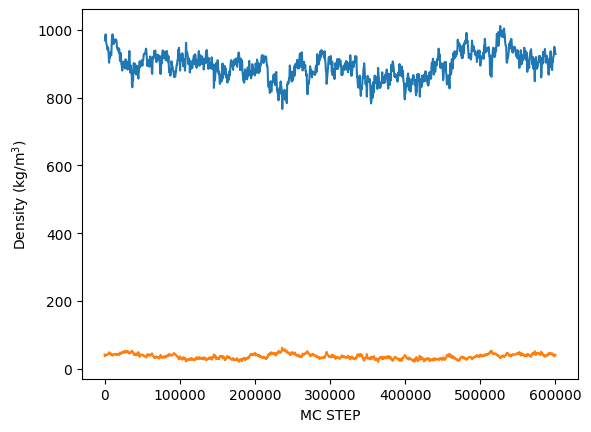

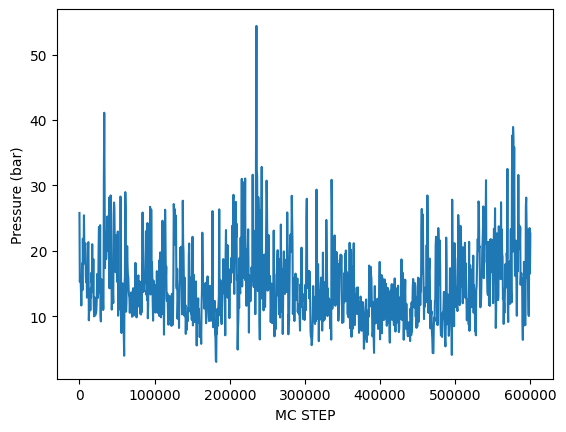

In [39]:
thermo = {}
thermo[1] = ThermoProps(f"gemc.out.box1.prp")
thermo[2] = ThermoProps(f"gemc.out.box2.prp")

plt.plot(thermo[1].prop("MC_STEP"), thermo[1].prop("Mass_Density"), label="Liquid")
plt.plot(thermo[2].prop("MC_STEP"), thermo[2].prop("Mass_Density"), label="Vapor")
plt.xlabel("MC STEP")
plt.ylabel("Density (kg/m$^3$)")

plt.show()

plt.plot(thermo[2].prop("MC_STEP"), thermo[2].prop("Pressure"), label="Vapor pressure")
plt.xlabel("MC STEP")
plt.ylabel("Pressure (bar)")

plt.show()